In [1]:
import torch
import torch.nn as nn
import cv2
import numpy as np

import os
import matplotlib.pyplot as plt
import time

from collections.abc import Iterable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

In [2]:
class ColorImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2RGB, transform=transforms.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs

#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [3]:
class OpenCVResize(object):

    def __init__(self, size):
        assert isinstance(size, int) or isinstance(size, Iterable) and len(size) == 2
        self.size = size

    def __call__(self, pic):
        return cv2.resize(np.array(pic), dsize=self.size, interpolation=cv2.INTER_NEAREST)


In [4]:
tf = transforms.Compose({
    OpenCVResize(size=(320, 180)),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
})

gray_dataset = ColorImageDataset(path='../dataset/color', transform=tf, code=cv2.COLOR_BGR2GRAY)
lab_dataset = ColorImageDataset(path='../dataset/color', transform=tf, code=cv2.COLOR_BGR2LAB)

In [5]:
torch.manual_seed(72)

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=12, shuffle=False)
# LAB IMAGES FOR VISUALIZATION AND TRAINING PURPOSE.
lab_data_loader = DataLoader(dataset=lab_dataset, batch_size=12, shuffle=False)
l_data_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=12, shuffle=False)
ab_data_loader = DataLoader(dataset=lab_dataset.ab_images(), batch_size=12, shuffle=False)

#### View a single batch grayscale and colored image sample.

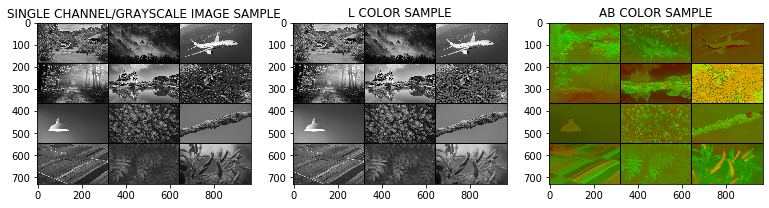

In [6]:
g_ims, l_ims, ab_ims, lab_ims = None, None, None, None
for g_ims in gray_data_loader:
    break

for l_ims in l_data_loader:
    break

for ab_ims in ab_data_loader:
    break

for lab_ims in lab_data_loader:
    break

plt.figure(figsize=(13, 14))

im = make_grid(g_ims, nrow=3, normalize=True)

plt.subplot(131)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(l_ims, nrow=3, normalize=True)

plt.subplot(132)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title("L COLOR SAMPLE")

im = make_grid(ab_ims, nrow=3, normalize=True)
im = np.stack([im[0], im[1], np.zeros((im.shape[1], im.shape[2]))])

plt.subplot(133)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title('AB COLOR SAMPLE')

plt.show()

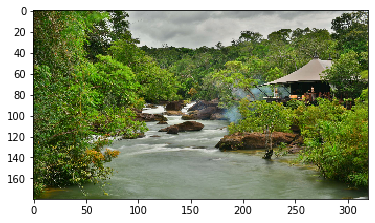

In [7]:
stack = np.stack([l_ims[0][0], ab_ims[0, 0], ab_ims[0, 1]], axis=0)
stack *= 255

stack = np.transpose(stack, (1, 2, 0)).astype(np.uint8)
stack = cv2.cvtColor(stack, code=cv2.COLOR_LAB2RGB)
plt.imshow(stack)

####  Convolutional Neural Network Model

In [14]:
class RGBNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=2, n_layers=(128, 84, 64, 32)):
        super().__init__()

        layers = []

        for nl in n_layers:
            layers.append(nn.Conv2d(in_channels=in_channels,
                                    out_channels=nl,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1))
            layers.append(nn.BatchNorm2d(nl))
            layers.append(nn.ReLU())
            in_channels = nl

        layers.append(nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=3,
                                stride=1,
                                padding=1))

        self.sequence = nn.Sequential(*layers)

    def forward(self, X):
        return self.sequence(X)


model = RGBNet()
model

RGBNet(
  (sequence): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(84, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

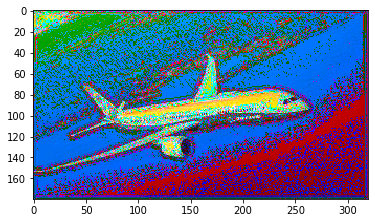

In [12]:
s = model(l_ims[2].view(-1, 1, 180, 320))
s = torch.stack([l_ims[2][0], s[0, 0], s[0, 1]]) * 255
s = np.transpose(s.detach().view(-1, 180, 320).numpy(), axes=(1, 2, 0)).astype(np.uint8)
s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

plt.imshow(s)

#### Training Neural Network Models


In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
epoch = 2
losses = []

start = time.time()

for i in range(epoch):
    i += 1

    # TRAIN RED MODEL.
    for batch, (X, y) in enumerate(zip(l_data_loader, ab_data_loader)):
        batch += 1

        y_pred = model(X)
        loss = criterion(y_pred, y)

        losses.append(loss)

        if batch == 1 or batch % 5 == 0:
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.3317857086658478
Epoch: 1, Batch: 5 -> Loss: 0.3326362669467926
Epoch: 1, Batch: 10 -> Loss: 0.16694599390029907
Epoch: 1, Batch: 15 -> Loss: 0.08392981439828873
Epoch: 1, Batch: 20 -> Loss: 0.04663528501987457
Epoch: 1, Batch: 25 -> Loss: 0.028494972735643387
Epoch: 1, Batch: 30 -> Loss: 0.034524817019701004
Epoch: 1, Batch: 35 -> Loss: 0.010904853232204914
Epoch: 2, Batch: 1 -> Loss: 0.01721416600048542
Epoch: 2, Batch: 5 -> Loss: 0.01852411963045597
Epoch: 2, Batch: 10 -> Loss: 0.020097671076655388
Epoch: 2, Batch: 15 -> Loss: 0.012067105621099472
Epoch: 2, Batch: 20 -> Loss: 0.01328711211681366
Epoch: 2, Batch: 25 -> Loss: 0.023948144167661667
Epoch: 2, Batch: 30 -> Loss: 0.01690792851150036
Epoch: 2, Batch: 35 -> Loss: 0.009130212478339672
Duration to total execution: 20.98 minutes


Text(0, 0.5, 'Loss')

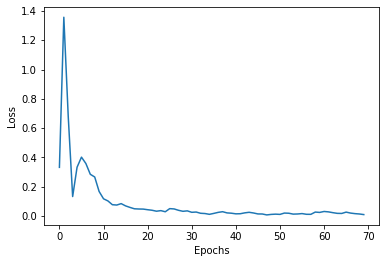

In [17]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

#### Validate images with same dataset used to train.

In [18]:
@torch.no_grad()
def validate(img):

    model.eval()

    ab = model(img)
    lab = np.stack([img[0, 0], ab[0, 0], ab[0, 1]]) * 255

    lab = np.transpose(lab, axes=(1, 2, 0)).astype(np.uint8)
    lab = cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)

    plt.imshow(lab)

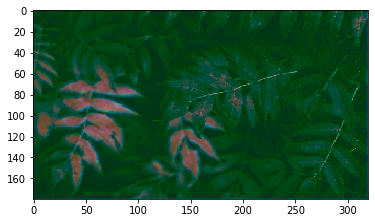

In [31]:
validate(g_ims[10].view(-1, 1, 180, 320))